#### This Python Notebook contains the tools for generating and analyzing initial guess trajectories for Earth-Moon impulsive transfer trajectories. We used these initial guesses for example 2 in our work at the 2025 AAS/AIAA Spaceflight Mechanics Meeting.
#### Refer to page 9 of this paper for the methodology: https://engineering.purdue.edu/people/kathleen.howell.1/Publications/Conferences/2020_AAS_SchMcCHow.pdf. Credit to the authors, Stephen Scheuerle, Brian McCarthy and Kathleen Howell

In [1]:
import sys
import os

project_path = '/workspace/apolune'
sys.path.append(project_path)

import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve, approx_fprime
import matplotlib.pyplot as plt
from API import api_get
from propagation import jacobi as prop_jacobi
import plotting
import manifold_tools
import poincare_tools
#from tqdm import tqdm

import spiceypy as spice
import init.load_kernels as krn

import dynamics.crtbp_dynamics as crtbp
import dynamics.rnbp_rpf_utils as utils
import dynamics_coeff.rnbp_rpf_utils as rnbp_utils
from dynamics_coeff.rnbp_rpf_dynamics_nonuniform_jit import get_body_states, compute_epoch_time

import frames.crtbp_transformations as crtbp_frame

import glob as glob

In [ ]:
krn.load_kernels()

G = 6.67408e-20  # [km^3 kg^−1 s^−2]
# AU = 149597870.693 # km
AU = 1.495978706136889e+08 # [km] from SPICE

observer_id = 0

# Attractors and their gravitational parameters
# spice.furnsh("kernels/pck/pck00010.tpc")  

# (index, spice_id) pairs
id_mer = [0, 1]
id_ven = [1, 2]
id_ear = [2, 399]
id_mar = [3, 4]
id_jup = [4, 5]
id_sat = [5, 6]
id_ura = [6, 7]
id_nep = [7, 8]
id_plu = [8, 9]
id_moo = [9, 301]
id_sun = [10, 10]

# Standard gravitational parameter ( μ [km^3 s−2] )
GM_sun = spice.bodvrd(str(id_sun[1]), "GM", 1)[1][0] 
GM_mer = spice.bodvrd(str(id_mer[1]), "GM", 1)[1][0] 
GM_ven = spice.bodvrd(str(id_ven[1]), "GM", 1)[1][0] 
GM_ear = spice.bodvrd(str(id_ear[1]), "GM", 1)[1][0] 
GM_moo = spice.bodvrd(str(id_moo[1]), "GM", 1)[1][0] 
GM_mar = spice.bodvrd(str(id_mar[1]), "GM", 1)[1][0] 
GM_jup = spice.bodvrd(str(id_jup[1]), "GM", 1)[1][0] 
GM_sat = spice.bodvrd(str(id_sat[1]), "GM", 1)[1][0] 
GM_ura = spice.bodvrd(str(id_ura[1]), "GM", 1)[1][0] 
GM_nep = spice.bodvrd(str(id_nep[1]), "GM", 1)[1][0] 
GM_plu = spice.bodvrd(str(id_plu[1]), "GM", 1)[1][0] 


id_primary = id_sun[0]
id_secondary = id_ear[0]

id_bodies = [id_mer[0], id_ven[0], id_ear[0], id_mar[0], id_jup[0], id_sat[0], id_ura[0], id_nep[0], id_plu[0], id_moo[0], id_sun[0]]
naif_id_bodies = [id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]]
mu_bodies = np.array([GM_mer, GM_ven, GM_ear, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu, GM_moo, GM_sun])

MU = mu_bodies[id_primary] + mu_bodies[id_secondary]
# https://www.jpl.nasa.gov/_edu/pdfs/scaless_reference.pdf
# https://www.jpl.nasa.gov/_edu/pdfs/ssbeads_answerkey.pdf
if id_primary == id_ear[0] and id_secondary == id_moo[0]:
    LU = 384400 # [km]
elif id_primary == id_sun[0] and id_secondary == id_ear[0]:
    LU = 1*AU 
elif id_primary == id_sun[0] and id_secondary == id_jup[0]:
    LU = 5.2*AU
else:
    raise ValueError("Invalid primary and secondary body combination")

TU = np.sqrt(LU**3 / MU) # scaling factor for time [s]
VU = LU / TU # [km/s]
om0 = 1/TU # constant [1/s] 

mu_crtbp = mu_bodies[id_secondary] / MU
mu_sun = mu_bodies[id_sun[0]] / MU

sun_angle_t0 = 0.671
om_sun = -9.25195985e-1
a_sun = 3.88811143e2

In [ ]:
def jacobi_guess(v0, mu, C_des, r0, deg):
    """
    Find the v0 necessary to maintain a set Jacobi Constant in CR3BP Parking orbit. For use with fsolve
    Args:
        v0 (float): Delta V applied in parking orbit to match desired Jacobi Constant
        mu (float): mass-ratio
        C_des (float): Jacobi Constant to match
        r0 (float): Parking orbit radius, ND
        deg (float): Angle around Earth

    Returns:
        C - C_Des (float): Difference between computed and desired Jacobi
    """
    states = [(r0*np.cos(deg) + (1 - mu)), 
        r0*np.sin(deg), 
        -(v0 - r0) * np.sin(deg), # v0 replaced with 0
        (v0 - r0) * np.cos(deg)] # v0 replaced with 0
    
    x = states[0]; y = states[1]
    x_dot = states[2]; y_dot = states[3]
    
    r = np.sqrt((x - 1 + mu)**2 + y**2)
    d = np.sqrt((x + mu)**2 + y**2 )
    U = (x**2 + y**2) / 2 + mu / r + (1 - mu) / d
    v = np.sqrt(x_dot**2 + y_dot**2)
    C = 2 * U - v**2
    
    return C - C_des

def periapse_stop(t, y, mu):
    # https://deepblue.lib.umich.edu/bitstream/handle/2027.42/42568/10569_2004_Article_405.pdf?sequence=1 (7)
    r = np.array(y[0:2]) - np.array([1-mu,0])
    r_dot = np.array(y[2:4])
    
    return np.dot(r, r_dot)

def threebody_orbit(t, x, mu):
    """
    The ODE function for the EOMs of the CR3BP

    Inputs:
    - t: The time
    - x: A numpy array of 4 elements, the orbit states x, y, x_dot, y_dot
    - mu: The only parameter of importance in the CR3BP
    """
    r = np.linalg.norm(x[0:2])

    xdot = np.empty((4,))
    xdot[0:2] = x[2:5]

    r1 = np.sqrt((x[0] + mu)**2. + x[1]**2.)
    r2 = np.sqrt((x[0] - 1. + mu)**2. + x[1]**2.)

    xdot[2] = 2.*x[3] + x[0] - ((1. - mu)*(x[0] + mu)/(r1**3.)) - (mu*(x[0] - 1. + mu)/(r2**3.))
    xdot[3] = -2.*x[2] + x[1] - ((1. - mu)*x[1]/(r1**3.)) - (mu*x[1]/(r2**3.))
    #xdot[5] = -((1. - mu)*x[2]/(r1**3.)) - (mu*x[2]/(r2**3.))

    return xdot

Iteration 0 of 20000
Found orbit with ToF 79.19 days
Found orbit with ToF 137.46 days
Found orbit with ToF 78.80 days
Found orbit with ToF 138.13 days
Iteration 1000 of 20000
Iteration 2000 of 20000
Iteration 3000 of 20000
Iteration 4000 of 20000
Iteration 5000 of 20000
Iteration 6000 of 20000
Iteration 7000 of 20000
Found orbit with ToF 79.09 days
Found orbit with ToF 79.13 days
Iteration 8000 of 20000
Iteration 9000 of 20000
Iteration 10000 of 20000
Iteration 11000 of 20000
Iteration 12000 of 20000
Iteration 13000 of 20000
Iteration 14000 of 20000


KeyboardInterrupt: 

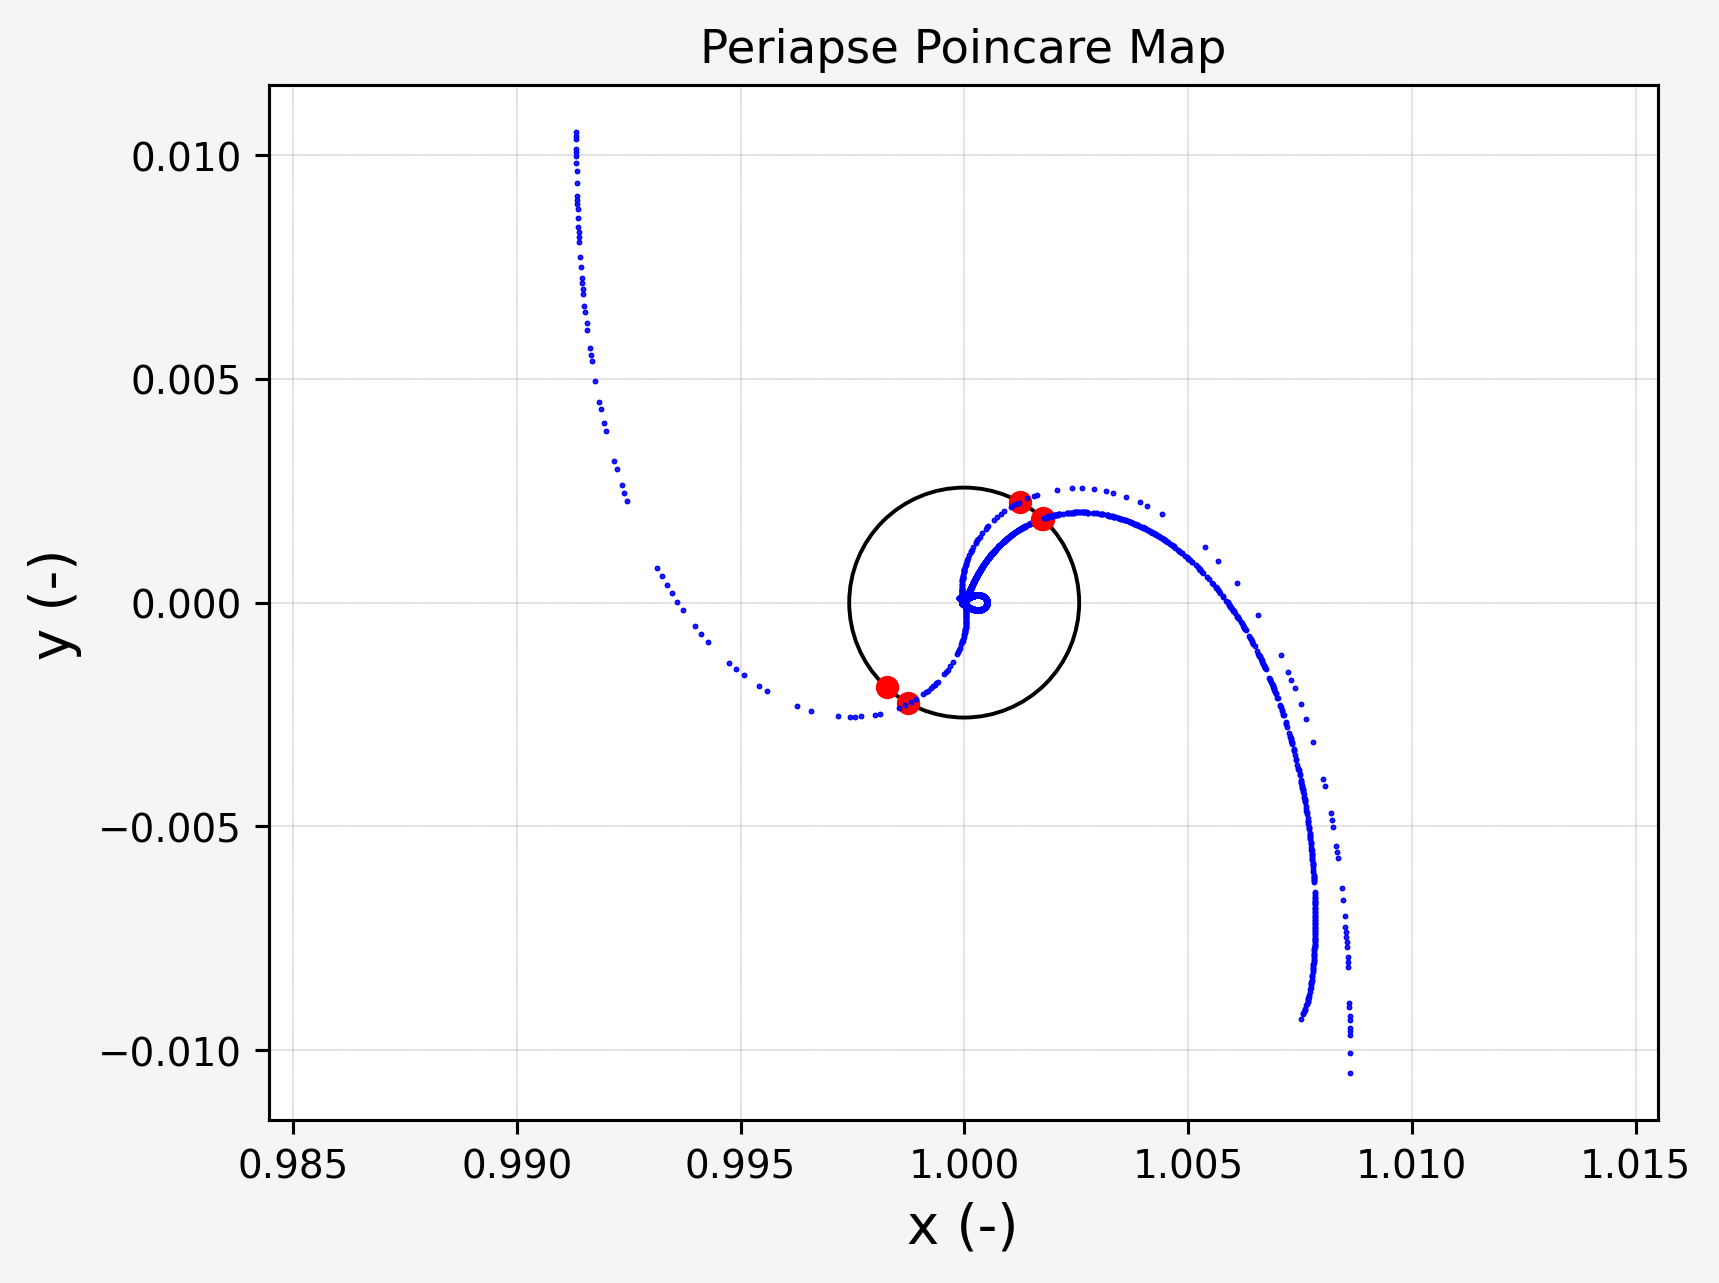

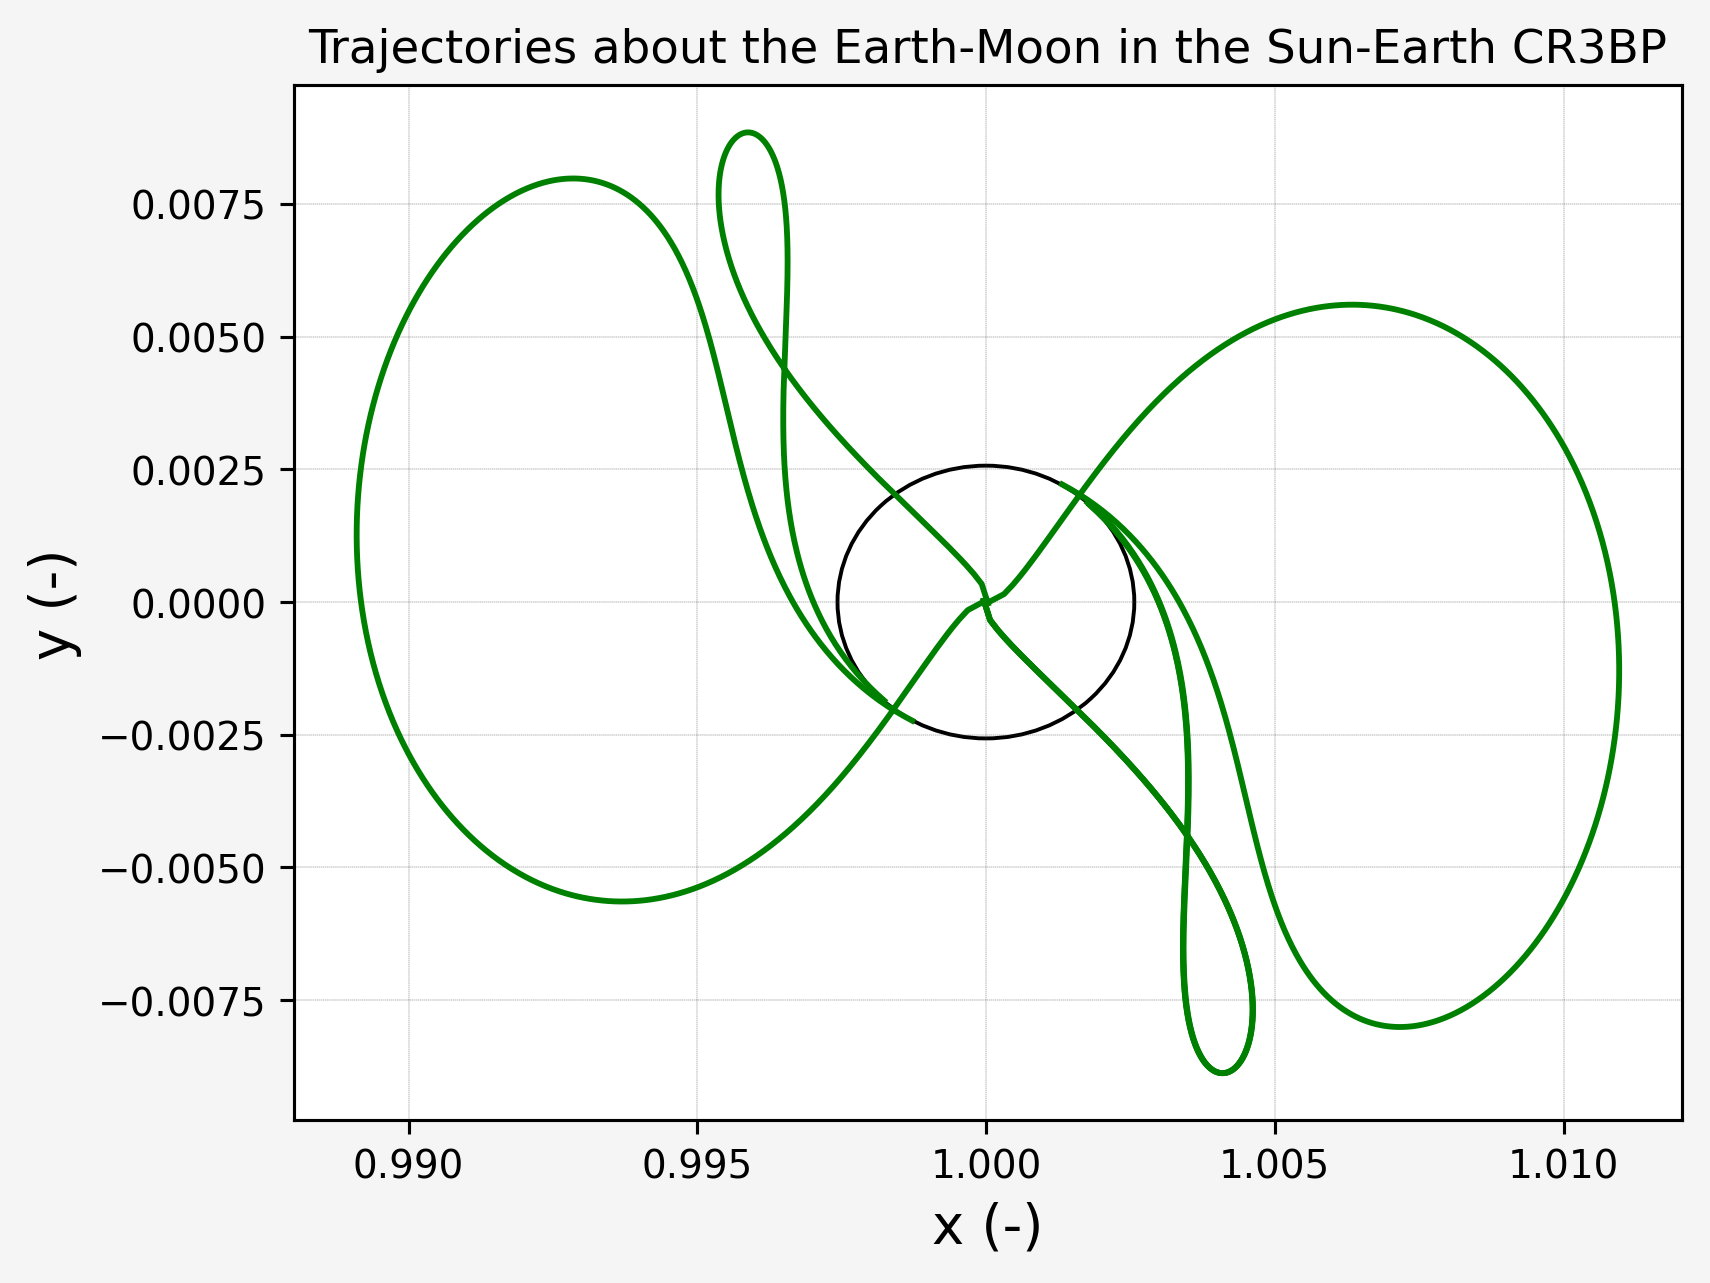

In [ ]:
# Initial conditions parking orbit around Earth
C = 3.000645 # Jacobi Constant, to be saved in the file name

r0 = (6378 + 150) / LU # 150 km parking orbit, non-dimensionalized
points = 20000 # Number of points to guess
alpha = np.linspace(0, 2*np.pi, points)

ICs = np.zeros([points, 4]) 
transfer_times = np.zeros(points)

# Perigee Calculation

s_year = 60*60*24*365
mu = mu_crtbp
t_vec_temp = np.linspace(0, s_year / TU, num=3000) # 365 day propagation
periapse = lambda t, y : periapse_stop(t, y, mu)
periapse.terminal = True
periapse.direction = 1

# Poincare Map
fig = plt.figure(dpi=280, facecolor='whitesmoke'); ax = plt.axes()
ax.set_facecolor('white')
ax.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
y_f = 384400 / LU # Nd Moon radius
circle2 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax.add_artist(circle2)
ax.axis('equal')
plt.title('Periapse Poincare Map')
plt.xlabel('x (-)', fontsize=14); plt.ylabel('y (-)', fontsize=14)

# Trajectories of orbits that get to the moon
fig2 = plt.figure(dpi=280, facecolor='whitesmoke'); ax2 = plt.axes()
circle3 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax2.add_artist(circle3)
ax2.set_facecolor('white')
ax2.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
plt.title('Trajectories about the Earth-Moon in the Sun-Earth CR3BP')
plt.xlabel('x (-)', fontsize=14); plt.ylabel('y (-)', fontsize=14)

threebody = lambda t, state : threebody_orbit(t, state, mu)
valid_orbits = 0 # Count how many orbits meet our condition
threebody_guesses = []

# For saving Poincare data
poincare_points = []
poincare_moon_periapse = []
moon_periapse_traj = []

for i in range(points):
    if i % 1000 == 0:
        print(f'Iteration {i} of {points}')
    
    deg = alpha[i]
    jacobi = lambda v0 : jacobi_guess(v0, mu, C, r0, deg)
    v0 = fsolve(jacobi, np.sqrt((1-mu)/r0)) # Find the delta-V to maintain Jacobi Constant
    ICs[i,:] = [(r0*np.cos(deg) + (1 - mu)), 
                r0*np.sin(deg),
                -(v0[0] - r0) * np.sin(deg),
                (v0[0] - r0) * np.cos(deg)]


    sol = solve_ivp(threebody, [t_vec_temp[0], t_vec_temp[-1]], ICs[i,:], 
        method = 'DOP853', t_eval = t_vec_temp, rtol=1e-10, atol=1e-10, events = periapse)
    
    if sol.y_events[0].any(): # Was apse ever achieved?
        for event in sol.y_events[0]: 
            r = event[0:2] - [1-mu,0]
            r_dot = event[2:4]
            r_dotdot = threebody_orbit(0, event, mu)
            
            if np.linalg.norm(r_dot)**2 + np.dot(r, r_dotdot[2:4]) > 0: # Was the event a periapse? Apoapse if D<0 [craig-davis thesis, 33]
                poincare_points.append(event)
                ax.plot(event[0], event[1], 'b.', markersize=1)
                if abs(np.linalg.norm(r) - y_f) <= 1780/LU: # Was the periapse within moon parking orbit? Moon radius + 40km
                    ax2.plot(sol.y[0], sol.y[1], 'g')    
                    ax.plot(event[0], event[1], 'r.', markersize=10)
                    poincare_moon_periapse.append([event[0], event[1], deg])
                    moon_periapse_traj.append({'sol': sol.y, 'deg': deg})

                    data = {}
                    x0 = [ICs[i, 0], ICs[i, 1], 0, ICs[i, 2], ICs[i, 3], 0]
                    xf = [event[0], event[1], 0, event[2], event[3], 0]
                    park = [(r0*np.cos(deg) + (1 - mu)), r0*np.sin(deg), 0, np.sin(deg), np.cos(deg), 0]

                    # Saved with the corresponding npy file
                    data['x0'] = x0
                    data['xf'] = xf
                    data['v0'] = v0[0] # Delta-V ND
                    data['v0skms'] = v0[0] * (1000 * VU) # Delta-V m/s
                    data['deg'] = deg # Earth parking orbit angle
                    data['tf'] = sol.t_events[0][0] # Time of flight
                    data['park'] = park # Parking orbit, no impulse

                    print(f'Found orbit with ToF {sol.t_events[0][0] * TU / (24*3600):.2f} days')
                    threebody_guesses.append(data)
                    valid_orbits += 1
                    
print(f'Found {valid_orbits} valid orbits.')

ax.axis('equal')
ax.set_xlim([1-mu -5E+5 / LU, 1-mu + 5E+5/ LU])
ax.set_ylim([-5E+5 / LU, 5E+5 / LU])

ax2.axis('equal')
ax2.set_xlim([1 -2E+6 / LU, 1 + 2E+6 / LU])
ax2.set_ylim([-2E+6 / LU, 2E+6 / LU])

if len(threebody_guesses) > 0:
    np.save(f'threebody_guesses_{str(C)}', threebody_guesses)
# Necessary to save several different arrays into one numpy file
np.savez(f'poincare_{str(C)}', threebody_guesses=threebody_guesses, 
    poincare_points=poincare_points, 
    poincare_moon_periapse=poincare_moon_periapse,
    moon_periapse_traj=moon_periapse_traj)

    

#### Plotting Functions

In [ ]:
def saveFigure(figureName, plt, path, **kwargs):
    '''
    Saves figure with given name. Credit to Dr. Ethan Burnett.
    '''
    save_opt = kwargs.get("save_opt", "pdf")
    figFileName = path+figureName+ "." + save_opt  # Also png
    plt.savefig(figFileName, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.05)
    print(f"Figure saved as {figFileName}")


#### Poincare Map Plotting Template

Figure saved as ./poincare_map.pdf


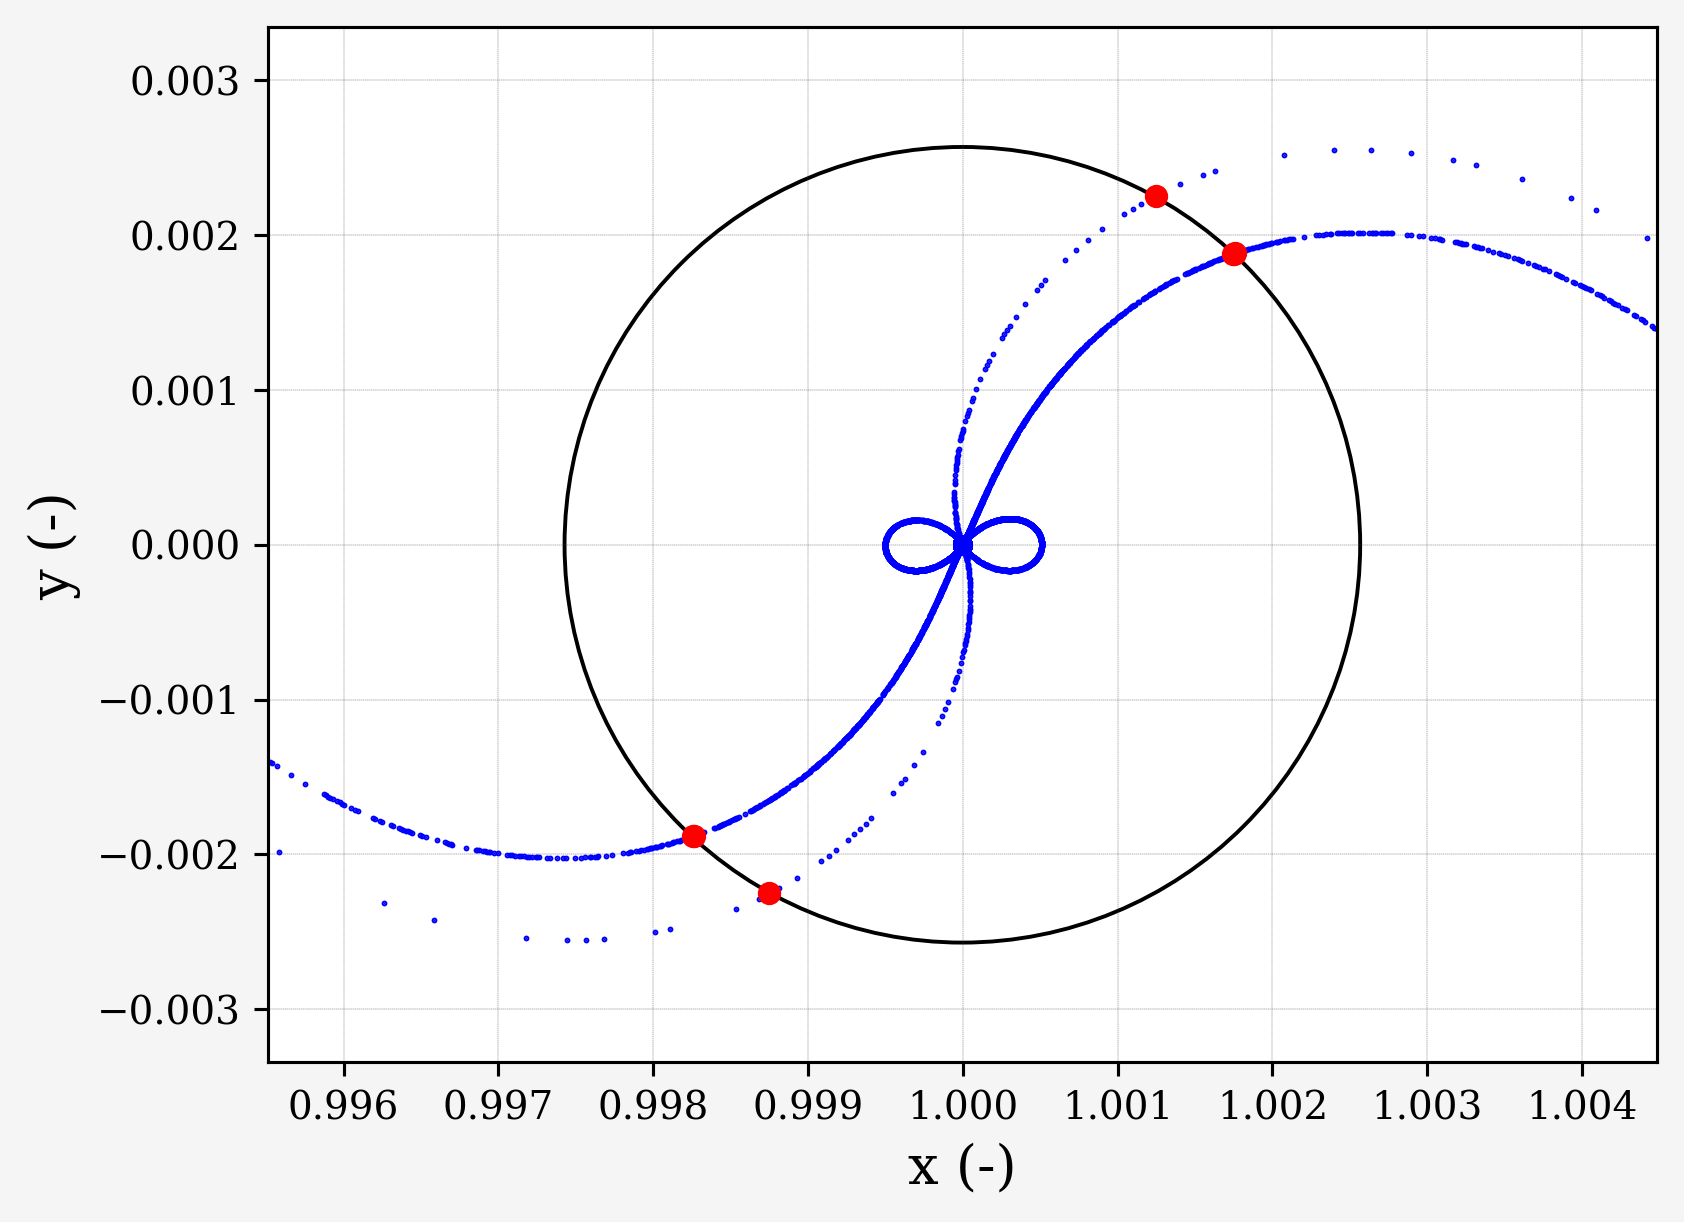

In [ ]:
# Plot the Poincare map from the saved data
fig, ax = plt.subplots(dpi=280, facecolor='whitesmoke')
ax.set_facecolor('white')
ax.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
circle = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax.add_artist(circle)
ax.axis('equal')
plt.xlabel('x (-)', fontsize=14)
plt.ylabel('y (-)', fontsize=14)
# Plot the points
for point in poincare_points:
    ax.plot(point[0], point[1], 'b.', markersize=1)
# Highlight the points that are within the moon's parking orbit
for point in poincare_moon_periapse:
    ax.plot(point[0], point[1], 'r.', markersize=10)
ax.set_xlim([1-mu - 5E+5 / LU, 1-mu + 5E+5 / LU])
ax.set_ylim([-5E+5 / LU, 5E+5 / LU])

saveFigure('poincare_map', plt, './')

Figure saved as ./guess_trajectories_single_jacobi.pdf


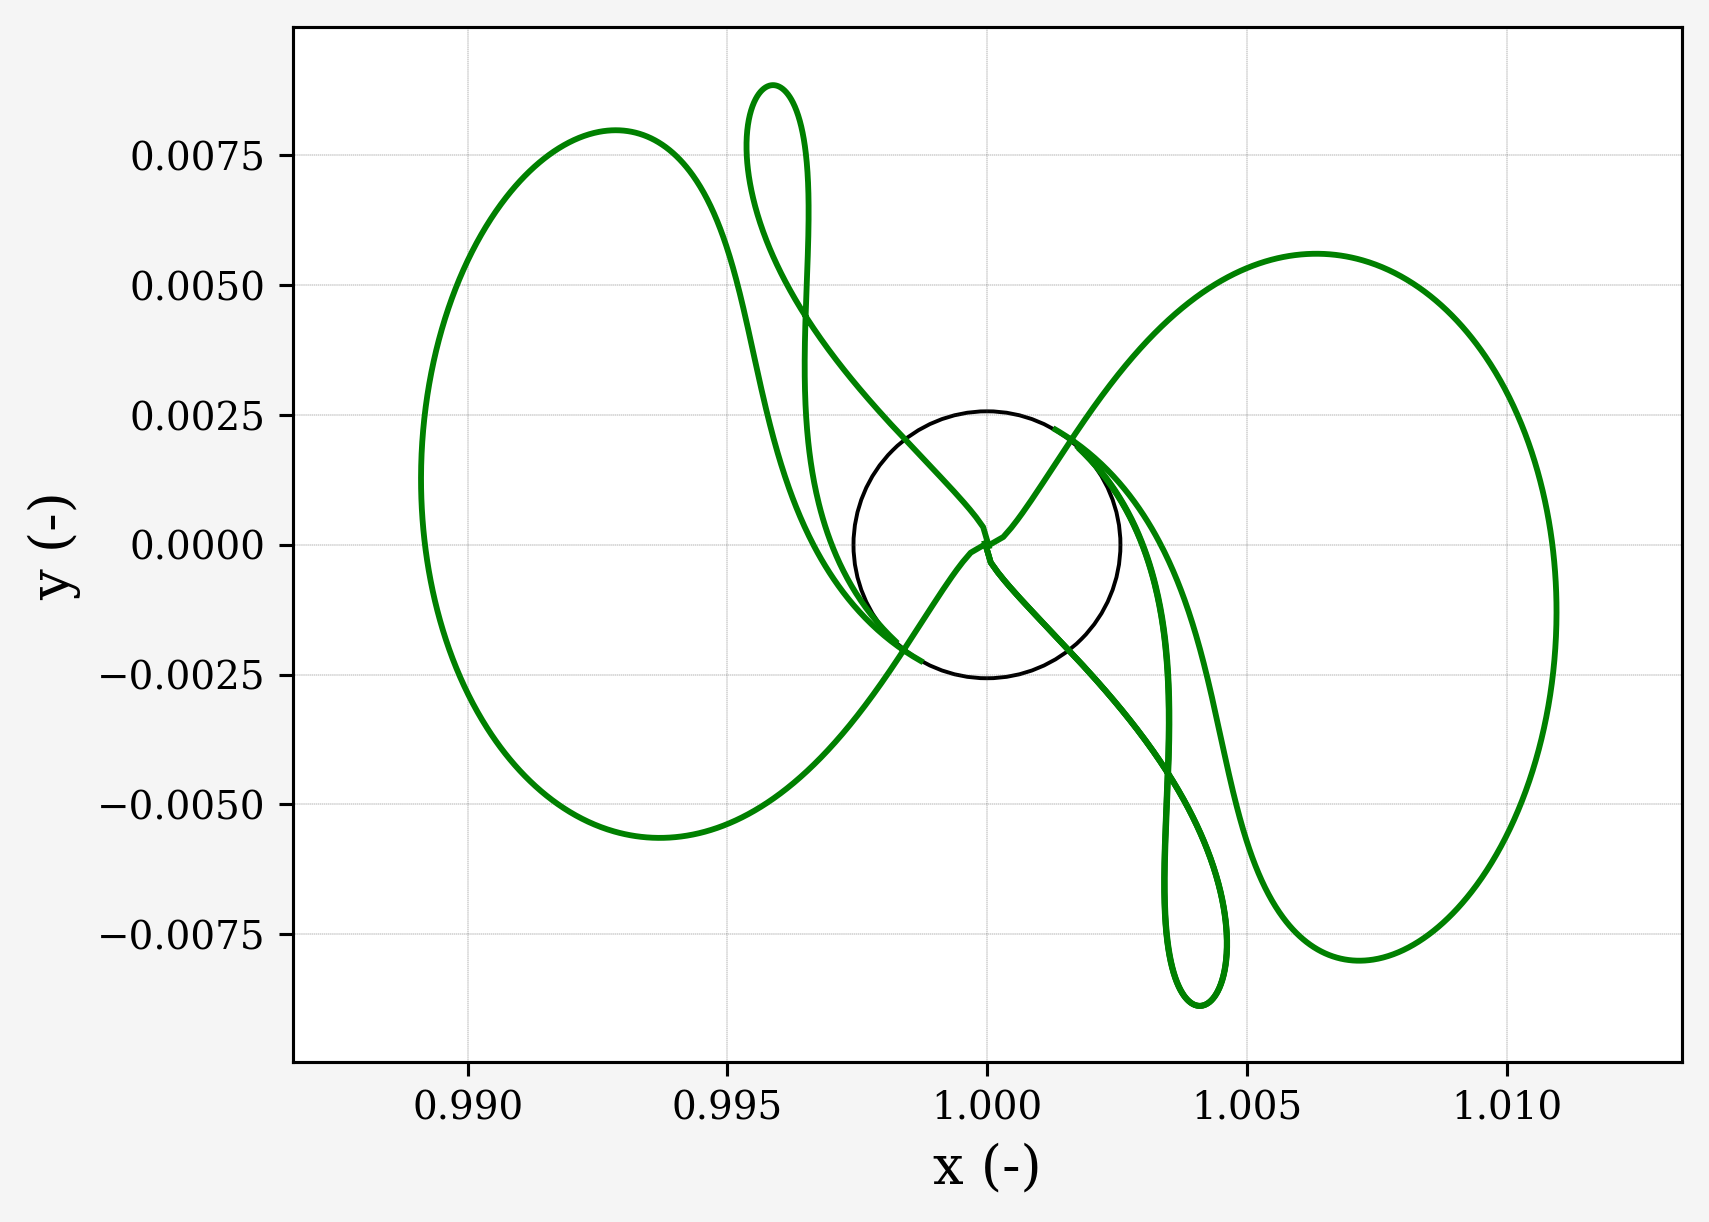

In [9]:
# Plot the trajectory from the data
fig3 = plt.figure(dpi=280, facecolor='whitesmoke')
ax3 = plt.axes()
circle4 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax3.add_artist(circle4)
ax3.set_facecolor('white')
ax3.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
plt.xlabel('x (-)', fontsize=14)
plt.ylabel('y (-)', fontsize=14)

for traj in moon_periapse_traj:
    ax3.plot(traj['sol'][0], traj['sol'][1], 'g')

ax3.axis('equal')
ax3.set_xlim([1 - 2E+6 / LU, 1 + 2E+6 / LU])
ax3.set_ylim([-2E+6 / LU, 2E+6 / LU])

saveFigure('guess_trajectories_single_jacobi', plt, './')

/tmp/ipykernel_775/4073343856.py:54: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  end_epoch = fsolve(moon_xy, epoch_t0) # Find the epoch where the moon is at xf
/tmp/ipykernel_775/4073343856.py:54: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  end_epoch = fsolve(moon_xy, epoch_t0) # Find the epoch where the moon is at xf


Figure saved as ./threebody_family.pdf


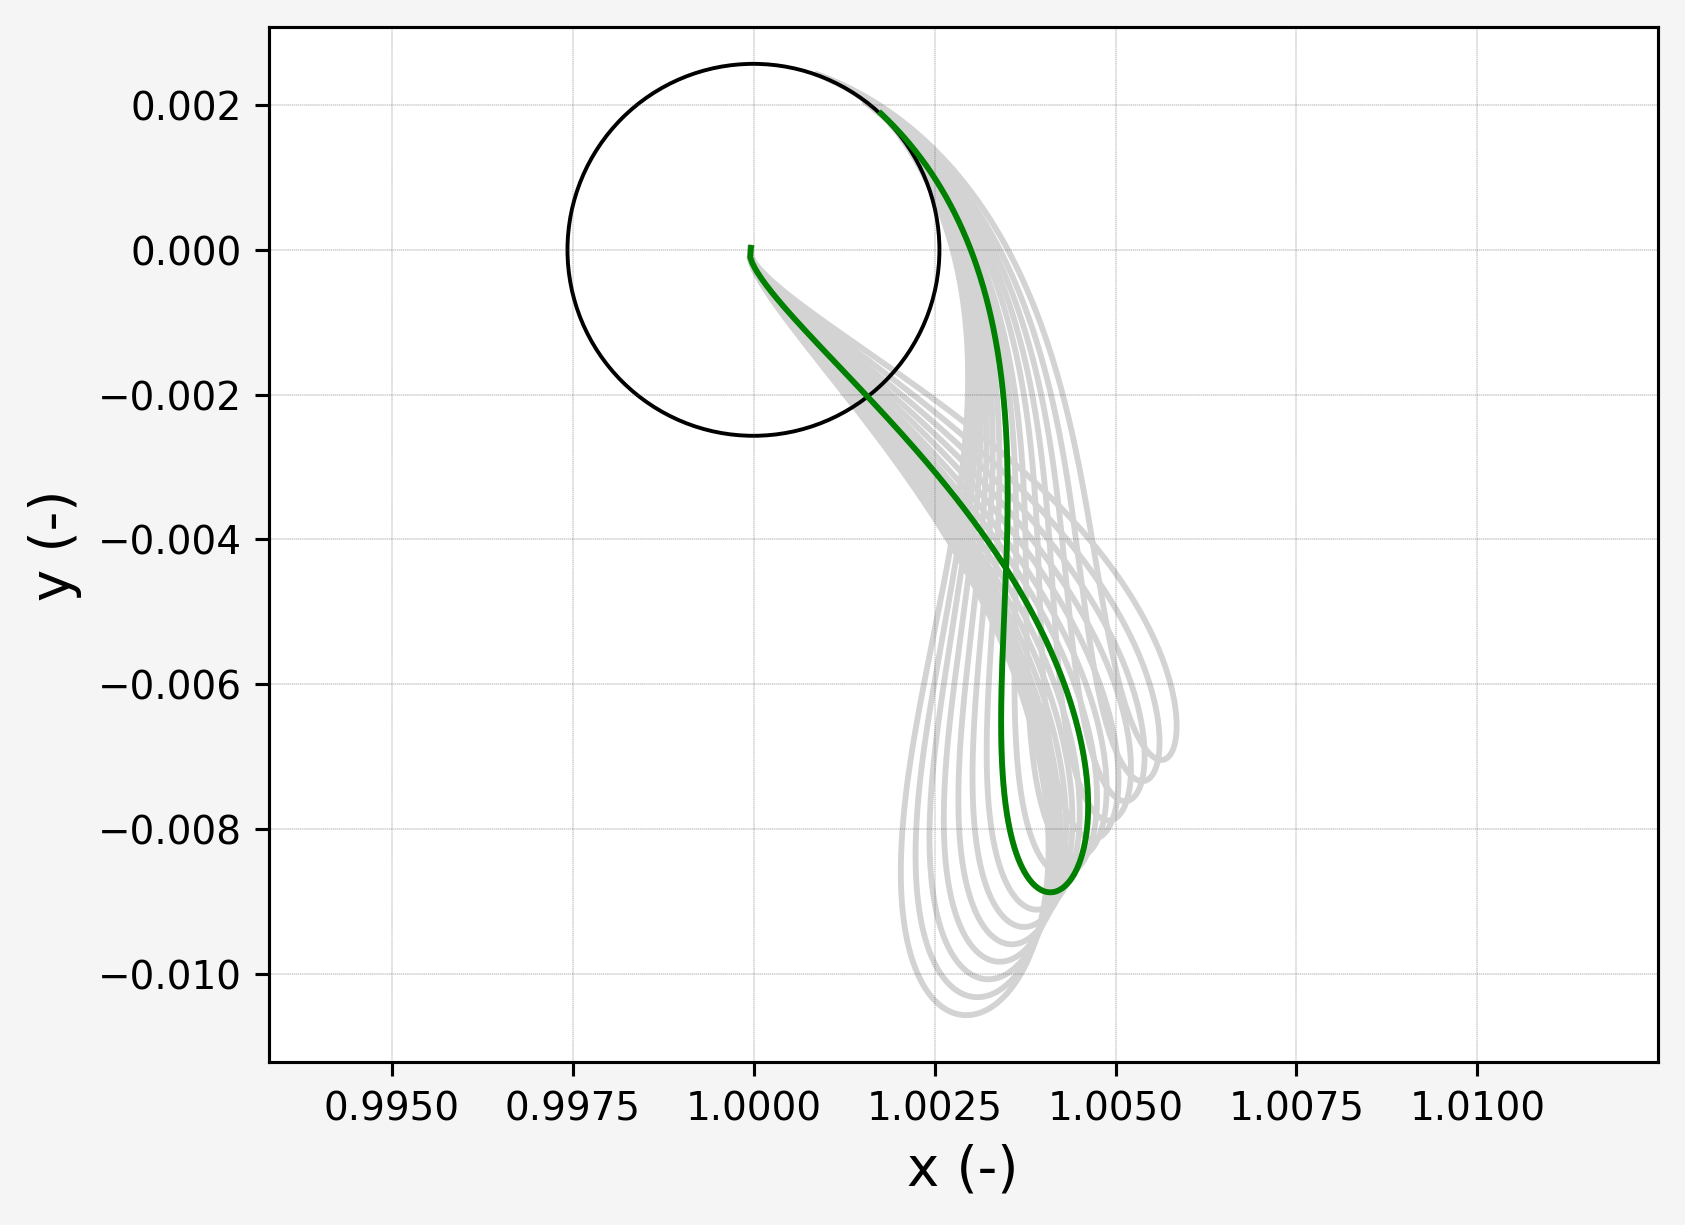

In [ ]:
# Plotting start and end points of the moon based on epoch. 
# Uses fsolve for finding the epoch backwards, from the closest moon position vs in CR3BP.
fig3 = plt.figure(dpi=280, facecolor='whitesmoke'); ax3 = plt.axes()
ax3.set_facecolor('white')
mu = mu_crtbp
y_f = 384400 / LU # Nd Moon radius
circle4 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax3.add_artist(circle4)
ax3.axis('equal')
ax3.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
#plt.title('Guesses about the Earth-Moon in the Sun-Earth CR3BP')
plt.xlabel('x (-)', fontsize=14); plt.ylabel('y (-)', fontsize=14)
plt.rc('font', family='serif')

# Start epoch finding values
ode_rtol = 1e-12; ode_atol = 1e-12
tau_0 = 0.0; tau_f = 1
t0 = 0.0
n_points = 5000
epoch_t0 = spice.str2et('1 June 2024 00:00:00 TDB')
reference_frame = "j2000"
mu_p = mu_bodies[id_primary]; mu_s = mu_bodies[id_secondary]
naif_id_p = naif_id_bodies[id_primary]; naif_id_s = naif_id_bodies[id_secondary]
tau_vec_input = np.linspace(tau_0, tau_f, n_points)
tau_vec, t_vec = rnbp_utils.compute_time(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)

threebody = lambda t, state : threebody_orbit(t, state, mu_crtbp)

def plot_family(npy, color='lightgray', zorder=0):
    data = np.load(npy, allow_pickle=True)
    #print(f'{len(data)} orbits')
    # For plotting just the first trajectory in this file, which was the family I wanted to plot.
    #if npy == 'threebody_guesses_3.000645.npy':
    #    data = [data[0]]

    input_dict = {
        "id_primary": id_primary,
        "id_secondary": id_secondary,
        "mu_bodies": mu_bodies,
        "naif_id_bodies": naif_id_bodies,
        "observer_id": id_ear[1], # I don't know why this works when it should be sun
        "reference_frame": reference_frame,
        "epoch_t0": epoch_t0
    }

    for orbit in data:
        t_vec_temp = np.linspace(0, orbit['tf'], num=3000)
        epoch_time = orbit['tf'] * TU + epoch_t0 # Seconds to xf
        #epoch_time = compute_epoch_time(tau, tau_vec, t_vec, epoch_t0)
        moon_state, _ = spice.spkgeo(id_moo[1], epoch_time, reference_frame, id_ear[1])
        moon_state = crtbp_frame.inertialEphemerisToSynodic(epoch_time, moon_state, input_dict)[0]
    
        # Messy way to find moon error, making a separate function fails because of numba
        moon_xy = lambda t: np.linalg.norm(np.subtract(crtbp_frame.inertialEphemerisToSynodic(t, spice.spkgeo(id_moo[1], t, reference_frame, id_ear[1])[0], input_dict)[0][0:2], orbit['xf'][0:2]))
        end_epoch = fsolve(moon_xy, epoch_t0) # Find the epoch where the moon is at xf
        start_epoch = end_epoch - orbit['tf'] * TU # The start epoch we should use in scp
        orbit['end_epoch'] = end_epoch[0]
        orbit['start_epoch'] = start_epoch[0]
        moon_state_start, _ = spice.spkgeo(id_moo[1], start_epoch, reference_frame, id_ear[1])
        moon_state_start = crtbp_frame.inertialEphemerisToSynodic(start_epoch, moon_state_start, input_dict)[0]
        moon_state_end, _ = spice.spkgeo(id_moo[1], end_epoch, reference_frame, id_ear[1])
        moon_state_end = crtbp_frame.inertialEphemerisToSynodic(end_epoch, moon_state_end, input_dict)[0]
        #print(f'stat time:{spice.et2utc(start_epoch, "C", 0)}')
        #print(f'end time:{spice.et2utc(end_epoch, "C", 0)}')
        #ax3.plot(moon_state_start[0], moon_state_start[1], 'go', markersize=5)
        #ax3.plot(moon_state_end[0], moon_state_end[1], 'bo', markersize=5)
    
        orbit['moon_state_start'] = moon_state_start
        orbit['moon_state_end'] = moon_state_end
        
        x0 = [orbit['x0'][0], orbit['x0'][1], orbit['x0'][3], orbit['x0'][4]]
        sol = solve_ivp(threebody, [t_vec_temp[0], t_vec_temp[-1]], x0, t_eval=t_vec_temp, method='DOP853', rtol=ode_rtol, atol=ode_atol)
        ax3.plot(sol.y[0,:], sol.y[1,:], color=color, label=f'deg: {orbit["deg"]:.5f}',zorder=zorder)
    np.save(npy, data)

#plot_family('threebody_guesses_3.000645.npy', color='green', zorder=10)

# For plotting multiple families in a branch. Figure 7c in our paper.
# Range of Jacobi Constants to plot around the central
jacobi_min = 3.000545
jacobi_max = 3.000745

npy_files = glob.glob('threebody_guesses_*.npy')
for npy_file in npy_files:
    jacobi_constant = float(npy_file.split('_')[-1].replace('.npy', ''))
    #if jacobi_min <= jacobi_constant <= jacobi_max: # Also for plotting the family of a branch
    if jacobi_constant in np.linspace(jacobi_min, jacobi_max, 15):
        # Central transfer to plot. See Figure 7c.
        #if jacobi_constant == 3.000645:
        #    plot_family(npy_file, color='green', zorder=10)
        plot_family(npy_file)
saveFigure('threebody_family', plt, './')

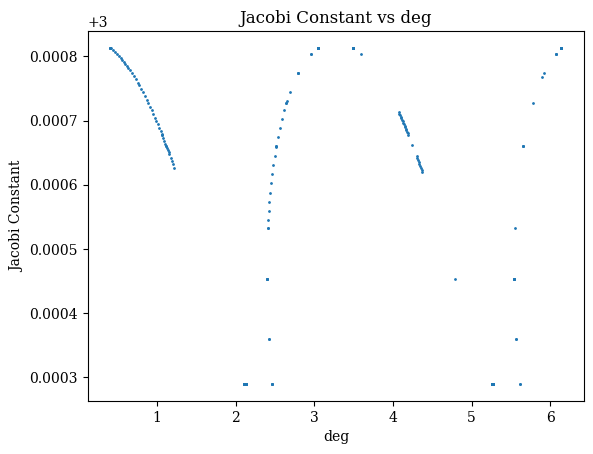

[(3.000813, 0.40797130170818763), (3.0006264644617184, 1.2193661443140547), (3.00029, 2.105579284081792), (3.00029, 2.129392794531107), (3.000453, 2.3944202010620073), (3.000745, 2.689739376586827), (3.000774, 2.790013277715508), (3.000774, 2.7912700404532176), (3.000804, 2.9571627218308967), (3.000813, 3.04731251525418), (3.000813, 3.4896531842863134), (3.000804, 3.588685997530015), (3.000713, 4.0715447945003165), (3.00062, 4.373328818977149), (3.000453, 4.792610351007811), (3.000453, 4.792610351007811), (3.00029, 5.257884875749707), (3.00029, 5.276420457761707), (3.000453, 5.543270006253109), (3.00066, 5.657317463800162), (3.000728, 5.779851830726856), (3.000728, 5.779851830726856), (3.000767, 5.89323787069797), (3.000774, 5.918724113243777), (3.000804, 6.068907260400085), (3.000813, 6.142691878776767)]


In [36]:
# Plotting the Jacobi Constant of a successful launch vs its launch degree (deg) 
# This plot shows the patterns for the initial conditions that are successful in reaching the moon.
# This is useful to for making manual guesses for the next code block which fills in the patterns
jacobi_constants = []
deg_values = []
npy_files = glob.glob('saved_guess_trajectories/threebody_guesses_*.npy')
for npy_file in npy_files:
    data = np.load(npy_file, allow_pickle=True)
    jacobi_constant = float(npy_file.split('_')[-1].replace('.npy', ''))
    for orbit in data:
        jacobi_constants.append(jacobi_constant)
        deg_values.append(orbit['deg'])

fig4 = plt.figure()
plt.scatter(deg_values, jacobi_constants, s=1)
plt.xlabel('deg')
plt.ylabel('Jacobi Constant')
plt.title('Jacobi Constant vs deg')
plt.show()

# Sort the deg_values and jacobi_constants together
sorted_deg_jacobi = sorted(zip(deg_values, jacobi_constants))
deg_values, jacobi_constants = zip(*sorted_deg_jacobi)

# Find the endpoints of the groups of data points
endpoints = [deg_values[0]]
for i in range(1, len(deg_values)):
    if deg_values[i] - deg_values[i-1] > 0.1:  # Assuming a gap of 0.1 to identify different groups
        endpoints.append(deg_values[i-1])
        endpoints.append(deg_values[i])
endpoints.append(deg_values[-1])

# Get the corresponding Jacobi constant for the deg endpoints
jacobi_endpoints = []
for endpoint in endpoints:
    for i in range(len(deg_values)):
        if deg_values[i] == endpoint:
            jacobi_endpoints.append(jacobi_constants[i])
            break

# Create tuples of the jacobi constants and the degs of the endpoints
jacobi_deg_tuples = list(zip(jacobi_endpoints, endpoints))
print(jacobi_deg_tuples)


Efficient but somewhat manual guess generation search method. Instead of searching through all degs of a Jacobi constant, which inevitably almost all will fail, use the succesful trajectory of a nearby Jacobi constant as an initial guess.

There is definitely a better and completely automatic way to fill in the guesses across Jacobi constants and branches. This could be its own work as an analysis of the structures that emerge in the guess methodology.

You will need to set the start and stop Jacobi constants so that you are searching along the correct branch.

In [35]:
# Initial conditions parking orbit around Earth
r0 = (6378 + 150) / LU # 150 km parking orbit, non-dimensionalized

# Perigee Calculation

s_year = 60*60*24*365
mu = mu_crtbp
t_vec_temp = np.linspace(0, s_year / TU, num=3000) # 365 day propagation
periapse = lambda t, y : periapse_stop(t, y, mu)
periapse.terminal = True
periapse.direction = 1

jacobi_constants = []
deg_values = []
npy_files = glob.glob('saved_guess_trajectories/threebody_guesses_*.npy')
for npy_file in npy_files:
    data = np.load(npy_file, allow_pickle=True)
    jacobi_constant = float(npy_file.split('_')[-1].replace('.npy', ''))
    if jacobi_constant > 3.0005:
        for orbit in data:
            if orbit['deg'] > 2:
                jacobi_constants.append(jacobi_constant)
                deg_values.append(orbit['deg'])
first = True
# The guess range for the degree
alpha1 = 1.16
alpha0 = 1.2193661443140547

C_guess_range = np.linspace(3.0006264644617184, 3.00050, 10)
for C in C_guess_range:
    # Starts from the last known succesful trajectory and then successively increases the angle (deg)
    # until a successful trajectory is found. However, if we go too far, possibly into the next known
    # trajectory or a preset stopping point, we backtrack and search more finely.
    factor = 10000 # Starting factor for the step size
    threebody_guesses = []
    found_orbit = False

    #min_deg = float('inf')
    #for i, jc in enumerate(jacobi_constants):
    #    if jc > C and deg_values[i] < min_deg:
    #        min_deg = deg_values[i]
    #alpha0 = min_deg
#
    #min_deg_less = float('inf')
    #for i, jc in enumerate(jacobi_constants):
    #    if jc < C and deg_values[i] < min_deg_less:
    #        min_deg_less = deg_values[i]
    #deg = alpha0
    
    if not first:
        deg = alpha1
    
    while(not found_orbit):
        
        jacobi = lambda v0 : jacobi_guess(v0, mu, C, r0, deg)
        v0 = fsolve(jacobi, np.sqrt((1-mu)/r0)) # Find the delta-V to maintain Jacobi Constant
        IC = [(r0*np.cos(deg) + (1 - mu)), 
                    r0*np.sin(deg),
                    -(v0[0] - r0) * np.sin(deg),
                    (v0[0] - r0) * np.cos(deg)]

        sol = solve_ivp(threebody, [t_vec_temp[0], t_vec_temp[-1]], IC, 
            method = 'DOP853', t_eval = t_vec_temp, rtol=1e-10, atol=1e-10, events = periapse)
        
        if sol.y_events[0].any(): # Was apse ever achieved?
            for event in sol.y_events[0]: 
                r = event[0:2] - [1-mu,0]
                r_dot = event[2:4]
                r_dotdot = threebody_orbit(0, event, mu)
                
                if np.linalg.norm(r_dot)**2 + np.dot(r, r_dotdot[2:4]) > 0: # Was the event a periapse? Apoapse if D<0 [craig-davis thesis, 33]
                    #diff = abs(np.linalg.norm(r) - y_f) - 1780/LU
                    if abs(np.linalg.norm(r) - y_f) <= 1780/LU: # Was the periapse within moon parking orbit? Moon radius + 40km
                        found_orbit = True
                        print(f'Found orbit with deg: {deg}, C: {C}')
                        first = False
                        alpha1 = deg

                        data = {}
                        x0 = [IC[0], IC[1], 0, IC[2], IC[3], 0]
                        xf = [event[0], event[1], 0, event[2], event[3], 0]
                        park = [(r0*np.cos(deg) + (1 - mu)), r0*np.sin(deg), 0, np.sin(deg), np.cos(deg), 0]

                        data['x0'] = x0
                        data['xf'] = xf
                        data['v0'] = v0[0] # Delta-V ND
                        data['v0skms'] = v0[0] * (1000 * VU) # Delta-V m/s
                        data['deg'] = deg # Earth parking orbit angle
                        data['tf'] = sol.t_events[0][0] # Time of flight
                        data['park'] = park # Parking orbit, no impulse

                        #print(f'Found orbit with ToF {sol.t_events[0][0] * TU / (24*3600):.2f} days')
                        threebody_guesses.append(data)
                        
                        continue
        deg += 2 * np.pi / factor
        if deg >= 1.5: # Adjust this as the stopping point for which to backtrack and search more finely
            deg = alpha1
            factor *= 2
            print(f'Went over, reducing step size')
        #print(f'deg: {deg:4f}, min_deg: {min_deg_less:4f}, diff: {abs(np.linalg.norm(r) - y_f) - 1780/LU}')

    if len(threebody_guesses) > 0:
        np.save(f'saved_guess_trajectories/threebody_guesses_{str(C)}', threebody_guesses)

Went over, reducing step size
Went over, reducing step size


KeyboardInterrupt: 